# Intro 2D Lattice Boltzmann Modeling

<a name="enable-gpu"></a>
**Note:** to enable the GPU in google colab, at the top click: *Runtime* $\rightarrow$ *Change Runtime Type* $\rightarrow$ *Hardware Accelerator* $\rightarrow$ GPU

---

**Don't Forget:**

>**“Premature optimization is the root of all evil.”**
>\-Donald Ervin Knuth, The Art of Computer Programming, Volume 1: Fundamental Algorithms


---
<a name="contents"></a>
### Contents
- [Numpy](#numpy)
- [Porespy](#porespy)
- [PyTorch](#pytorch-gpu)
- [Appendix](#appendix)

---

<img src="https://drive.google.com/uc?export=view&id=1--tpZH8RMbAwKDkB8-c5hB-gMgp8dQaH" width="500" height="300"/>



This is code is adapted from the [coursera course](https://www.coursera.org/learn/modeling-simulation-natural-processes) on "Simulation and modeling of natural processes" ([view original code](https://raw.githubusercontent.com/Sinnefa/Simulation-and-Modeling-of-Natural-Processes-Coursera-May-2020/master/Code/lbmFlowAroundCylinder.py)). These are the people who wrote the code-base for Palabos (C++). While this is simple and not written for ultra-high-performance, it is easy to disect and can help you to understand how LBMs work.  Palabos does a good job of abstracting a lot of the detail away, but for research it can be handy to see a simple LBM which you can modify and test and experiment with. If you don't want to bother with learning Palabos, there are some options you can consider for getting performance out of a python program such as MPI for python and Cuda / GPU programming (Cuda is Nvidia's language for GPU programming). [Cupy](https://cupy.dev/) (Cuda-Python) is a system that is trying to be a [drop-in replacement for numpy](https://docs.cupy.dev/en/stable/reference/comparison.html), likewise [PyTorch](https://pytorch.org/) (which is used here) has a tensor class and many functions which can be easily ported to GPUs that is very performant. A third option is JAX from google which is another numpy-replacement which can run on the GPU and has jit (just in-time compilation) which can compile functions at run-time and make them run extremely fast.

Performance comparison for 1000 iterations of flow past a cylinder:

| nx  | ny  | Numpy  | PyTorch (GPU \| CPU) | speedup (torch GPU $\leftrightarrow$ numpy) |
| --- | --- | ---   | --- | --- |
| 420 | 180 | ~22 s  | ~( 9 \| 17 ) s | 2.44 $\times$ |
| 1000 | 300 | ~89 s  | ~( 15 \| 55 )s | 5.93 $\times$ |
| 4200 | 1800 | ~44 min.   | ~( 4 \| 26 ) min  | 11 $\times$

This is pretty significant for the ease of implementation (tensors need to be moved onto the GPU with .cuda()). There is no message passing interface.



---
---
---
<a name="numpy"></a>
# Numpy LBM

[link](#contents) to contents

This code is taken directly from the coursera course. (J. Latt et. al)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time as ti
from matplotlib import cm
from tqdm import tqdm

### Extract macroscopic parameters

This function returns the macroscopic variables density (rho = $\rho$; rank-2 tensor $\rightarrow$ scalar at every discrete lattice point) and velocity (u; rank-3 tensor x and y velocity at every discrete lattice point). 


In [2]:
def macroscopic(fin, nx, ny, v):
    rho = np.sum(fin,axis=0)
    u = np.zeros((2,nx,ny))
    for i in range(9):
        u[0,:,:] += v[i,0]*fin[i,:,:]
        u[1,:,:] += v[i,1]*fin[i,:,:]
    u /= rho
    return rho, u

### Equilibrium

This function returns the equilibrium distribution

In [3]:
def equilibrium(rho, u, v, t, nx, ny):
    usqr = (3/2)*(u[0]**2+u[1]**2)
    feq = np.zeros((9,nx,ny))
    for i in range(9):
        cu = 3*(v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
        feq[i,:,:] = rho*t[i]*(1+cu+0.5*cu**2-usqr)
    return feq

## Flow obstacle

The numpy function *fromfunction* uses this function to broadcast the coordinates of the 'obstacle.' This currying is just to make a function that doesn't need any global variables. You can think about how you would use something like porespy or a CT scan to generate a porous medium that you could substitute for this function.

In [4]:
def obstacle_fun(cx, cy, r):
    def inner(x, y):
        return (x-cx)**2+(y-cy)**2<r**2
    return inner

## Inlet velocity

This function instantiates the inlet boundary velocity (with a small perturbation).

In [5]:
def inivel( uLB, ly):
    def inner(d,x,y):
        return (1-d) * uLB * (1+1e-4*np.sin(y/ly*2*np.pi))
    return inner
inivel(0.1, 1)(0, 0, 0.5)

0.1

## Model Parameters

**Lattice Numbering Scheme:**

![](https://drive.google.com/uc?export=view&id=1MeGFRsq7ogNlymNrHNseXnoYQ2D_NHcA)

If you look at the array **v** these are the vectors that it contains.

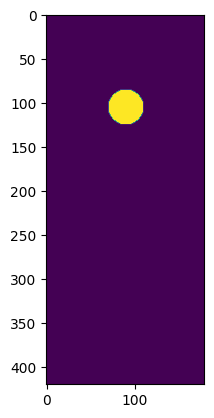

In [6]:
Re = 10.0                  # Reynolds number
#------------------------------------------------------------------------------
maxIter = 1000
nx,ny = 420,180             # Domain dimensions
ly = ny-1
uLB = 0.04                  # Inlet velocity NON PHYSICAL??
cx,cy,r = nx//4,ny//2,ny/9  # cylinder coordinates and radius (as integers)
nulb = uLB*r/Re             # Viscosity
omega = 1 / (3*nulb+0.5)    # Relaxation parameter

# lattice velocities
v = np.array([ 
            [1,1],
            [1,0],
            [1,-1],
            [0,1],
            [0,0],
            [0,-1],
            [-1,1],
            [-1,0],
            [-1,-1]
            ])

# weights
t = np.array([ 
            1/36,
            1/9,
            1/36,
            1/9,
            4/9,
            1/9,
            1/36,
            1/9,
            1/36
            ])

col_0 = np.array([0,1,2])
col_1 = np.array([3,4,5])
col_2 = np.array([6,7,8])

# instantiate the cylindrical obstacle
obstacle = np.fromfunction(obstacle_fun(cx,cy,r),(nx, ny))
if True:
  plt.imshow(obstacle)

# initial velocity profile
vel = np.fromfunction(inivel(uLB,ly),(2,nx,ny))

# initialize fin to equilibirum (rho = 1)
fin = equilibrium(1,vel,v,t,nx,ny)

In [7]:
# example of rolling a 2D array
'''
        fin[i,:,:] = np.roll(  
                          np.roll(
                                fout[i,:,:], v[i,0], axis = 0
                               ),
                          v[i,1], axis = 1 
                          )
'''
a2d = np.repeat(np.array([[[1,2,3],[4,5,6],[7,8,9]]]), 9, axis=0)

fin = a2d

# lattice velocities
v = np.array([ 
            [1,1],
            [1,0],
            [1,-1],
            [0,1],
            [0,0],
            [0,-1],
            [-1,1],
            [-1,0],
            [-1,-1]
            ])

for i in range(len(v)):
    fin[i,:,:] = np.roll(  
                    np.roll(
                            fin[i,:,:], v[i,0], axis = 0
                            ),
                    v[i,1], axis = 1 
                    )

In [8]:
# same as roll but with cat
# fin[i] = cat((fout[i, :, -v[i,0]:], fout[i, :, :-v[i,0]]), dim=2)
# fin[i] = cat((fout[i, -v[i,1]:, :], fout[i, :-v[i,1], :]), dim=1)

a2d = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])

v = torch.tensor([-1,1])

# cat((a2d[:, -v[0]:], a2d[:, :v[1]]), dim=1)
a2d[:, -v[0]:], a2d[:, :-v[1]]

NameError: name 'torch' is not defined

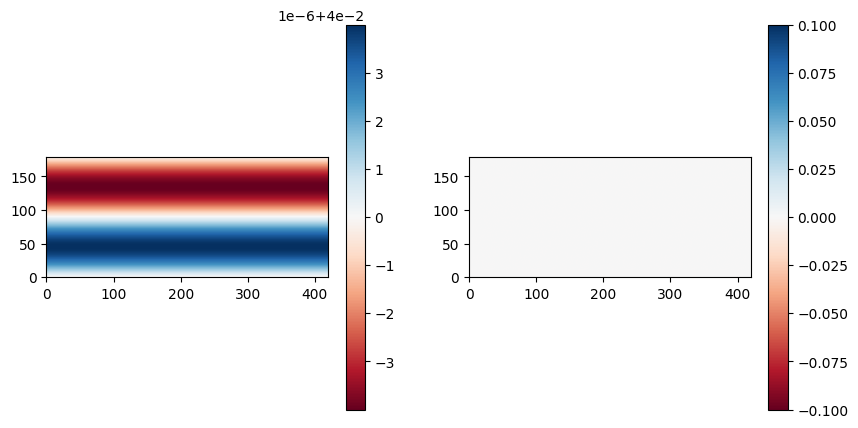

In [9]:
# plots the x and y velocities
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(vel[0].T,origin='lower',cmap=cm.RdBu)
plt.colorbar()
plt.subplot(122)
plt.imshow(vel[1].T,origin='lower',cmap=cm.RdBu)
plt.colorbar()
plt.show()


## Time Stepping Loop

100%|██████████| 1000/1000 [00:10<00:00, 94.34it/s]


time to execute =  10.60207486152649


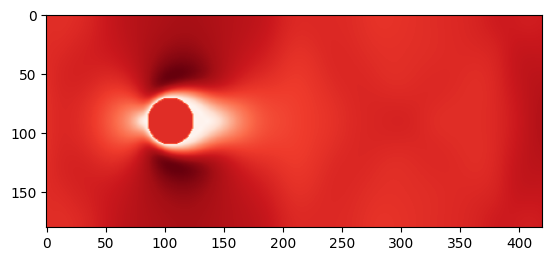

In [46]:
#==============================================================================
#   Time-Stepping
#==============================================================================
t0 = ti()
for time in tqdm(range(maxIter)):
    # outflow boundary condition (right side) NEUMANN BC! No gradient
    fin[col_2,-1,:] = fin[col_2,-2,:]

    # compute macroscopic variables
    rho,u = macroscopic(fin,nx,ny,v)

    # inlet boundary condition (left wall)
    u[:,0,:] = vel[:,0,:]
    rho[0,:] = 1/(1-u[0,0,:])*( np.sum(fin[col_1,0,:], axis = 0)+
                                2*np.sum(fin[col_2,0,:], axis = 0))

    feq = equilibrium(rho,u,v,t,nx,ny)
    fin[col_0,0,:] = feq[col_0,0,:] + fin[col_2,0,:]-feq[col_2,0,:]

    # Collide
    fout = fin - omega*(fin-feq)

    # bounceback
    for i in range(9):
        fout[i,obstacle] = fin[8-i,obstacle]

    # stream
    for i in range(9):
        # be careful with this -> numpy.roll cycles through an array by an axis
        # and the last element becomes the first. this implements a periodic
        # boundary in a very compact syntax, but needs to be reworked for other
        # implementations
        fin[i,:,:] = np.roll(  
                          np.roll(
                                fout[i,:,:], v[i,0], axis = 0
                               ),
                          v[i,1], axis = 1 
                          )

    # Output an image every 100 iterations
    if (time%100 == 0):
        plt.clf()
        plt.imshow(np.sqrt(u[0]**2+u[1]**2).T, cmap = cm.Reds)
        plt.savefig("vel{0:03d}.png".format(time//100))
tf = ti() - t0
print("time to execute = ",tf)

---
---
---
<a name="porespy"></a>
# Light intro to porespy + analysis

[link](#contents) to contents

This just goes over basic instantiation of porous domains with the *ps.generators*


In [9]:
# Uncomment the next line to install porespy
# !pip install -q porespy==1.0.0
import porespy as ps
from skimage.measure import regionprops,label
import numpy as np

ImportError: cannot import name 'marching_cubes_lewiner' from 'skimage.measure' (/Users/aidanbx/miniconda/envs/cv/lib/python3.10/site-packages/skimage/measure/__init__.py)

### Parameters

These are some arbitrary parameters as argument for porespy generators. 



In [ ]:
dim = 200
X,Y,Z = dim,dim,dim
shape = [X,Y]             # for 3D generators, add Z to this list
porosity = 0.9
blobiness = 1
ncylinders = 100 

### Generators

Note that some of the generators take different kwargs. To see what the names of the kwargs are for a generator use:

```python
# example
help(ps.generators.blobs)
```

This prints out the the Parameters that can be passed to this function as keyword arguments.

There are two outputs that the generators in porespy produce:
1. nd-arrays of booleans 
2. nd-arrays of floats.

In [ ]:
#help(ps.generators.blobs)
#===============================================================================
#   bool 
#-------------------------------------------------------------------------------
im = ~ps.generators.blobs( shape=shape,
                           porosity = porosity,
                           blobiness=blobiness)
#im = ps.generators.cylinders(   shape=shape,
#                                radius = radius,
#                                ncylinders = ncylinders,
#                                theta_max = 90,
#                                phi_max = 90)
#im = ps.generators.overlapping_spheres(shape=shape,
#                                       radius = radius,
#                                       porosity = porosity)
#im = ps.generators.polydisperse_spheres(   shape=shape,
#                                           dist = dist,
#                                           porosity = porosity)

#===============================================================================
#   float
#-------------------------------------------------------------------------------
#im = ps.generators.bundle_of_tubes(shape=shape,
#                                   spacing = 4)
#im = ps.generators.generate_noise(shape=shape)

### Visualization
notes:
- visualiztion.sem and xray only take binary or boolean arrays

-------------------------------------------------------
porosity =  0.895475
mean "fiber" diameter =  12.060132308424363  pixels
-------------------------------------------------------


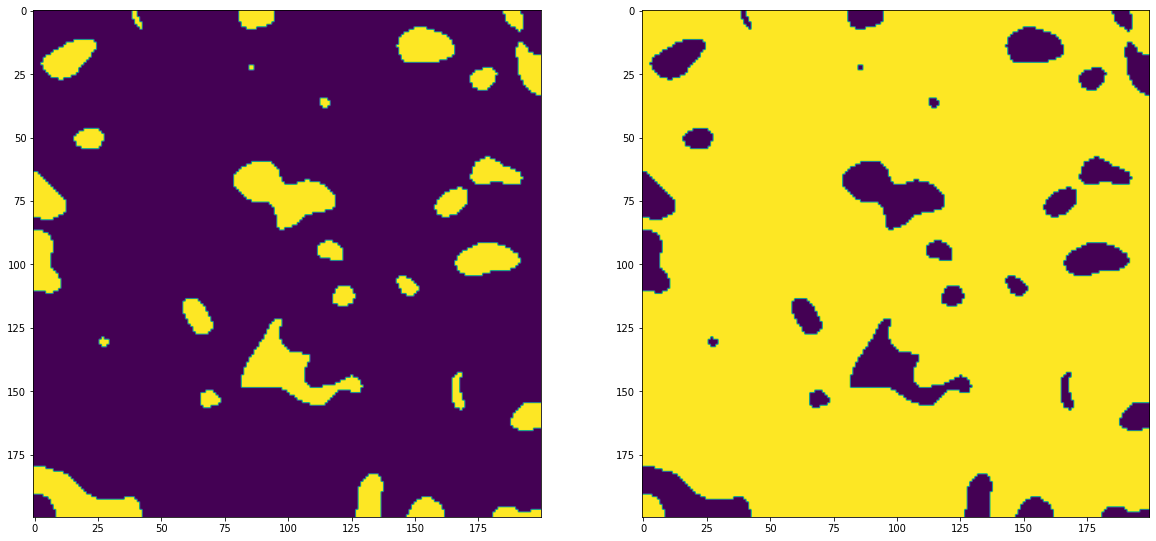

In [ ]:
fs = (10,10)
fig,ax = plt.subplots(1,2, figsize = (20,10))
ax[0].imshow(im)
ax[1].imshow(ps.visualization.sem(im))                            # nothing for 2D domains
#area = region_surface_areas(im)
labels = label(im)                                              # segment image
props = regionprops(labels)                                     # return properties of segmented image
fiber_dia = np.mean([el.equivalent_diameter for el in props])   # avg. fiber diameter
print("-"*55)
print('porosity = ',1-ps.metrics.porosity(im))
print('mean "fiber" diameter = ',fiber_dia," pixels")
print("-"*55)

### Interfacing with coursera LBM code

You might try something like this for replacing obstacle_fun in your code. (Don't forget to put this tensor onto the GPU if you are using cuda.)

Note: tilde (~) is boolean negate.

porosity =  0.8971296296296296
mean "fiber" diameter =  5.669143835909224  pixels


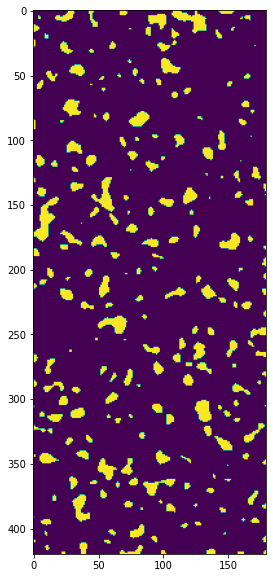

In [ ]:
kwargs = {
          'shape':[420,180],
          'porosity':.9,
          'blobiness':3
          }

obstacle = ~ps.generators.blobs(**kwargs)
obstacle = ~ps.generators.blobs(**kwargs)

# Metrics for this domain
labels = label(obstacle)                                              # segment image
props = regionprops(labels)                                     # return properties of segmented obstacleage
fiber_dia = np.mean([el.equivalent_diameter for el in props])   # avg. fiber diameter
print('porosity = ',1-ps.metrics.porosity(obstacle))
print('mean "fiber" diameter = ',fiber_dia," pixels")
plt.figure(figsize = (10,10))
plt.imshow(obstacle)

---
---
---

<a name="pytorch-gpu"></a>
# Pytorch

[link](#contents) to contents

- [How to enable gpu in google colab](#enable-gpu)

**Note** the method *.to(device)* ports tensors to the current device which can be the GPU or CPU. You can use *.cuda()* if you always have a dedicated GPU available, but using *.to(device)* is safer and more portable. Use *.cpu()* to bring tensors back to the CPU, (if they are already present then this operation does nothing).  Calling this method is the only difference between running the code on the [CPU](#pytorch-cpu) and GPU.


I haven't really looked into this, but it might be possible to write this program such that it can utilize [TorchScript](https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html) which (I think) compiles it to a an intermediary representation (C++?) and can make it more performant still.

Again, I modified this code on the fly, so there are still probably some things that can be optimized here.

In [47]:
from time import time as ti
from matplotlib import cm
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import fromfunction
from numpy import pi
import numpy as np

In [48]:
from torch import zeros,tensor,roll,sin,sqrt,linspace,cat
from torch import sum as tsum
import torch

### Device selection

You can select the device if you know it is an available resource, or you can use this little conditional to select 'cuda' (GPU) if its available and it will default to 'cpu' if it is not.

In [102]:
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')
# #-------------------------------------------------------------------------------
# # Uncomment the next line to hard code the use of cpu
# #device = torch.device('cpu')
# #-------------------------------------------------------------------------------

print('Using device:', device)



True
True
Using device: mps


### Extract macroscopic parameters

This function returns the macroscopic variables density (rho = $\rho$) and velocity (u). This is used to extract the macroscopic velocity from the densities at a lattice point.

Refer to **equation 15** page 34 from Lattice Boltzmann Modeling - An Introduction for Geoscientists and Engineers

$$\bf{u} = \frac{1}{\rho}\Sigma_{a = 0}^8f_{a}e_a$$


v is our variable for the lattice velocities which is the same as $\bf{e}$ where the subscript a refers to the [0,8] lattice direction and fin is the directional density ($f_a$ in equation 15).

In [50]:
def macroscopic(fin, nx, ny, v):
    rho = tsum(fin,axis=0).to(device)
    u = zeros((2,nx,ny)).to(device)
    for i in range(9):
        u[0,:,:] += v[i,0]*fin[i,:,:]
        u[1,:,:] += v[i,1]*fin[i,:,:]
    u /= rho
    return rho, u

### Equilibrium

This function returns the equilibrium distribution

Refer to **equation 17** page 35 from Lattice Boltzmann Modeling - An Introduction for Geoscientists and Engineers.

$$f_a^{eq}(\bf{x}) = w_a\rho (\bf{x}) \bigg[ 1 + 3\frac{\bf{e_a \cdot u}}{c^2} + \frac{9}{2}\frac{(\bf{e_a\cdot u})^2}{c^4} - \frac{3}{2}\frac{u^2}{c^2}\bigg] $$

| symbol | description |
| --- | --- |
| $f_a^{eq}(x)$ | equilibrium distribution for direction a at lattice point x|
| $w_a$ | weight for direction a |
| $\rho(x)$ | density at lattice point x|
| $e_a$ | lattice velocity in direction a |
| $\bf{u}$ | velocity (vector) |
| $c$ | basic speed on the lattice  |

In this function:
1. **usqr** is the last term inside the square brackets
2. instantiate equilibrium distribution tensor
3. **cu** is the dot product of the velocity components ($v \cdot u$) $\times$ 3
4. **rho** is the density, **t** is the weight vector the parentheses hold the bracketed terms in the equation:
  - 1
  - cu $\rightarrow 3 \times (v \cdot u)$
  - 0.5 * cu**2 $\rightarrow \frac{9}{2} \times (v \cdot u)^2$
  - usqrt $\rightarrow \frac{3}{2}\frac{u^2}{c^2}$


In [51]:
def equilibrium(rho, u, v, t, nx, ny):
    usqr = (3/2)*(u[0]**2+u[1]**2)
    feq = zeros((9,nx,ny))
    for i in range(9):
        cu = 3*(v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
        feq[i,:,:] = rho*t[i]*(1+cu+0.5*cu**2-usqr)
    return feq.to(device)

## Flow obstacle

The numpy function *fromfunction* uses this function to broadcast the coordinates of the 'obstacle.' This currying is just to make a function that doesn't need any global variables. You can think about how you would use something like porespy or a CT scan to generate a porous medium that you could substitute for this function.

Alternately you can use the porespy generators to create a porous domain

In [52]:
def obstacle_fun(cx, cy, r):
    def ret_fun(x, y):
        return (x-cx)**2+(y-cy)**2<r**2
    return ret_fun
    
def obstacle_porous(**kwargs):
  return ~kwargs['generator'](**kwargs)

## Inlet velocity

This function instantiates the inlet boundary velocity (with a small perturbation).

In [53]:
def inivel( uLB, ly, d, nx, ny):
  _,yy = torch.meshgrid(linspace(0,nx-1,nx),linspace(0,ny-1,ny))
  yy.to(device)
  vel = zeros((d,nx,ny)).to(device)
  for dir in range(d):
    vel[dir,:,:] = (1-dir) * uLB * (1+1e-4*sin(yy/ly*2*pi))
  return vel

## Model Parameters

**Lattice Numbering Scheme:**

![](https://drive.google.com/uc?export=view&id=1MeGFRsq7ogNlymNrHNseXnoYQ2D_NHcA)



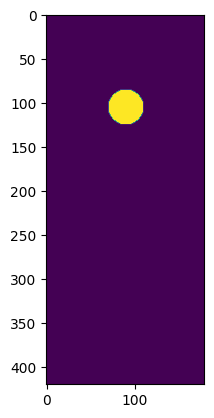

In [54]:
Re = 10.0                  # Reynolds number
#------------------------------------------------------------------------------
maxIter = 1000              # Total number of iterations
nx,ny = 420,180             # Domain dimensions (lattice nodes)
ly = ny-1                   # Height of the domain in lattice units
uLB = 0.04                  # Velocity in lattice units
cx,cy,r = nx//4,ny//2,ny/9  # Cylinder coordinates and radius (as integers)
nulb = uLB*r/Re             # Viscosity in lattice units
omega = 1 / (3*nulb+0.5)    # Relaxation frequency

# lattice velocities
v = tensor([ 
            [1,1],
            [1,0],
            [1,-1],
            [0,1],
            [0,0],
            [0,-1],
            [-1,1],
            [-1,0],
            [-1,-1]
            ]).int().to(device)

# weights
t = tensor([ 
            1/36,
            1/9,
            1/36,
            1/9,
            4/9,
            1/9,
            1/36,
            1/9,
            1/36
            ]).float().to(device)

# these variables used to group indices
col_0 = tensor([0,1,2]).long().to(device)
col_1 = tensor([3,4,5]).long().to(device)
col_2 = tensor([6,7,8]).long().to(device)

#------------------------------------------------------------------------------
# instantiate the obstacle
#obstacle = tensor(fromfunction(obstacle_fun(cx,cy,r),(nx, ny))).to(device)
# kwargs['shape'] = [nx,ny]
obstacle = tensor(fromfunction(obstacle_fun(cx,cy,r),(nx, ny))).to(device)
#obstacle = torch.tensor(fromfunction(obstacle_fun(cx,cy,r),(nx, ny)))
plt.imshow(obstacle.cpu())
#------------------------------------------------------------------------------

# initial velocity profile
vel = inivel(uLB, ly, 2, nx, ny)

#--------------------------------------------------------------
# initialize fin to equilibirum (rho = 1)
fin = equilibrium(1,vel,v,t,nx,ny).to(device)


## Time Stepping Loop

Note the stream / collision equation is **equation 16** page 35 from Lattice Boltzmann Modeling....

$$f_a(x+e_a\Delta t,t+\Delta t) = f_a(x,t) - \frac{[f_a(x,t)-f_a^{eq}(x,t)]}{\tau}$$

Where:
$$stream \rightarrow f_a(x+e_a\Delta t,t+\Delta t) = f_a(x,t)$$
$$collide \rightarrow - \frac{[f_a(x,t)-f_a^{eq}(x,t)]}{\tau}$$

Note: $\omega = \frac{1}{\tau}$

In [55]:
#==============================================================================
#   Time-Stepping
#==============================================================================
t0 = ti()
for time in tqdm(range(maxIter)):
    # outflow boundary condition (right side) NEUMANN BC! No gradient
    fin[col_2,-1,:] = fin[col_2,-2,:]

    # compute macroscopic variables
    rho,u = macroscopic(fin,nx,ny,v)

    # inlet boundary condition (left wall)
    u[:,0,:] = vel[:,0,:]
    rho[0,:] = 1/(1-u[0,0,:])*( tsum(fin[col_1,0,:], axis = 0)+
                                2*tsum(fin[col_2,0,:], axis = 0))

    # Equilibrium
    feq = equilibrium(rho,u,v,t,nx,ny)

    fin[col_0,0,:] = feq[col_0,0,:] + fin[col_2,0,:]-feq[col_2,0,:]

    # Collide
    fout = fin - omega*(fin-feq)

    # bounceback: 
    # refer to the lattice numbering scheme to see 8-i is always the opposite of 
    # direction i!
    for i in range(9):
        fout[i,obstacle] = fin[8-i,obstacle]

    # # stream
    # for i in range(9):
    #     # be careful with this -> roll cycles through an array by an axis
    #     # and the last element becomes the first. this implements a periodic
    #     # boundary in a very compact syntax, but needs to be reworked for other
    #     # implementations
    #     fin[i,:,:] = roll(  
    #                       roll(
    #                             fout[i,:,:], v[i,0].item(), dims = 0
    #                            ),
    #                       v[i,1].item(), dims = 1 
    #                       )
    for i in range(9):
        # Be careful with indexing
        # [:, :, :-v[i,0]] returns all elements except the last v[i,0] rows
        # [:, :-v[i,1]] returns all elements except the last v[i,1] columns
        fin[i] = cat((fout[i, :, -v[i,0]:], fout[i, :, :-v[i,0]]), dim=2)
        fin[i] = cat((fout[i, -v[i,1]:, :], fout[i, :-v[i,1], :]), dim=1)

    # Output an image every 100 iterations
    if (time%100 == 0):
        plt.clf()
        u_cpu = u.cpu()
        x_temp = int(round(5*nx/ny))
        y_temp = int(round(5))
        plt.imshow(sqrt(u_cpu[0]**2+u_cpu[1]**2).T, cmap = 'Reds')
        #plt.axis('equal')
        #plt.savefig("vel{0:03d}.png".format(time//100))
tf = ti() - t0
print("time to execute = ",tf)

  0%|          | 0/1000 [00:00<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [34]:
a = np.array([[[1,2,3],[4,5,6],[7,8,9]]])

i=0
a[i,:,:] = np.roll(  
    np.roll(
        a2d[i,:,:], v[i,0], axis = 0
        ),
    v[i,1], axis = 1 
)

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

---
---
---
<a name="appendix"></a>

# Appendix: Plotting Lattice directions

[link](#contents) to contents

This is just for being OCD about the figures showing the lattice directions.

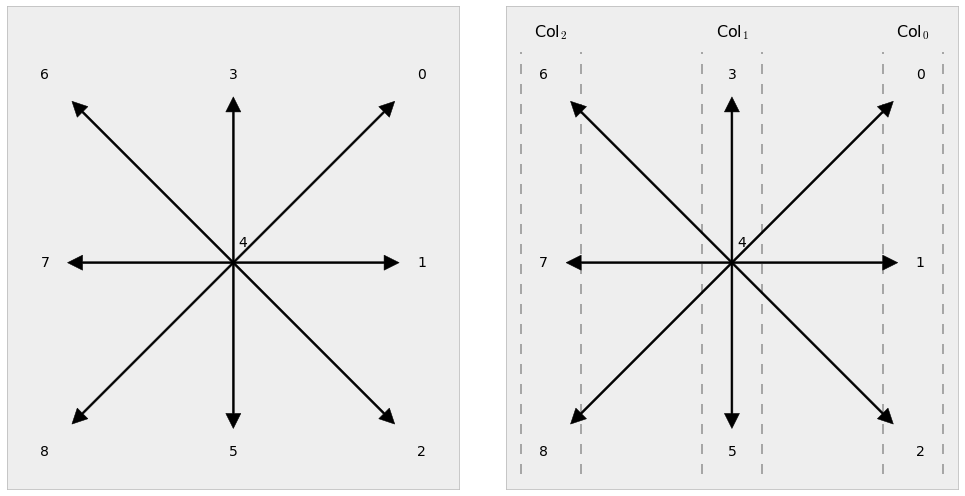

In [ ]:
fontsize = 14
length = 2
plt.style.use('bmh')
def draw_lattice(   ax, coords, width=.025, head_width=.2, head_length=.2,
                    annotation_offset=1.25):
    ax.arrow(   0,0,coords[0],coords[1],
                width = width,
                head_length=head_width,
                head_width=head_length,
                color = 'k')
    aos = annotation_offset
    ax.annotate(coords[2],xy=(aos*coords[0],aos*coords[1]),xytext=(aos*coords[0],aos*coords[1]),
                horizontalalignment = 'center',
                verticalalignment = 'center',
                fontsize = fontsize)

def plot_column(ax,x0,x2,y, alpha = 0.3):
  for x in [x0,x2]:
    ax.plot([x,x],[-y/2,y/2],'k', linestyle = (0,(5,5)), alpha = alpha)

def lattice_fig(fig, ax, coords):
    for pair in coords:
        draw_lattice(ax,pair)
    #plt.box(False)
    ax.set_xlim(-length*1.5,length*1.5)
    ax.set_ylim(-length*1.5,length*1.7)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_aspect('equal')
    ax.xaxis.set_tick_params(bottom=False,top=False,right=False,left=False)
    ax.yaxis.set_tick_params(right=False,left=False)


#==============================================================================
# Draw D2Q9 Lattice
#==============================================================================
op = [
        (length,length,'0'),
        (length,0,'1'),
        (length,-length,'2'),
        (0,length,'3'),
        (0,-length,'5'),
        (-length,length,'6'),
        (-length,0,'7'),
        (-length,-length,'8'),
        ]

fig,ax = plt.subplots(1, 2, num  = 0,figsize = (14,7))
xval = .066
yval = .185
for a in ax:
  lattice_fig(fig,a,op)
  a.annotate('4',xy=(xval,yval),xytext=(xval,yval),
              horizontalalignment = 'left',
              verticalalignment = 'bottom',
              fontsize = fontsize)
  a.grid(False)
# Overlaying the Columns
dx = .4
dy = .4
fs = 16
plot_column(ax[1], length, length*(1+dx), length*(1+dy)*2)
plot_column(ax[1], -length, -length*(1+dx), length*(1+dy)*2)
plot_column(ax[1], -dx, dx, length*(1+dy)*2)
# Annotations for column names
ax[1].text(length*1.2,  length*1.5,'Col$_0$', horizontalalignment = 'center', fontsize = fs)
ax[1].text(0,           length*1.5,'Col$_1$', horizontalalignment = 'center', fontsize = fs)
ax[1].text(-length*1.2, length*1.5,'Col$_2$', horizontalalignment = 'center', fontsize = fs)
fig.tight_layout()
plt.savefig("lattice_diagram.png")
plt.show()